In [1]:
import numpy as np

%matplotlib notebook
%autosave 1

import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.special import gammaln
from paglm.chebyshev import compute_chebyshev
from paglm.model import *
# import seaborn as sns
from scipy.linalg import hankel

Autosaving every 1 seconds


<IPython.core.display.Javascript object>


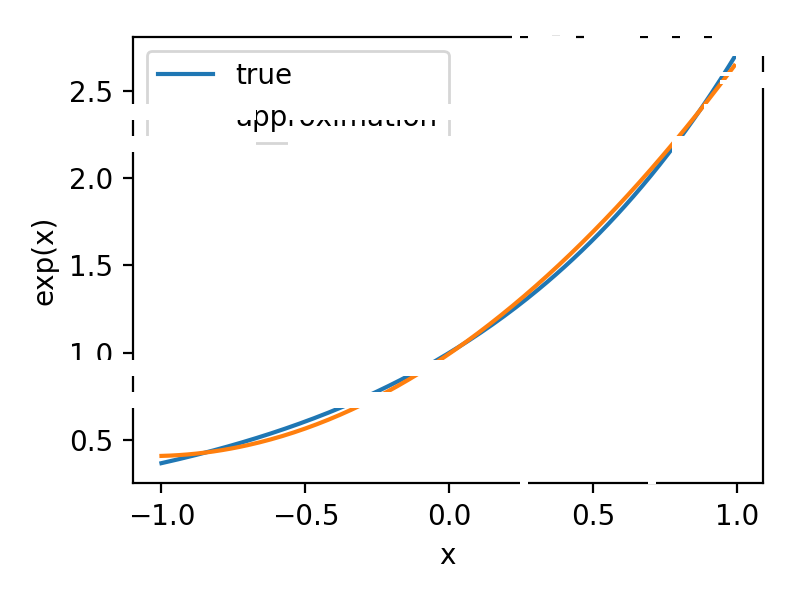

In [2]:
# example polynomial approximation
xlim = np.array([-1.0,1.0]) 
a,b,c = compute_chebyshev(np.exp,xlim,power=2,dx=0.01)

xx = np.arange(xlim[0],xlim[1],0.01)
plt.figure(figsize=[4,3])
plt.plot(xx,np.exp(xx))
plt.plot(xx,a + b*xx + c*(xx**2))
plt.legend(["true","approximation"])
plt.xlabel("x")
plt.ylabel("exp(x)")
plt.tight_layout()

26


<IPython.core.display.Javascript object>


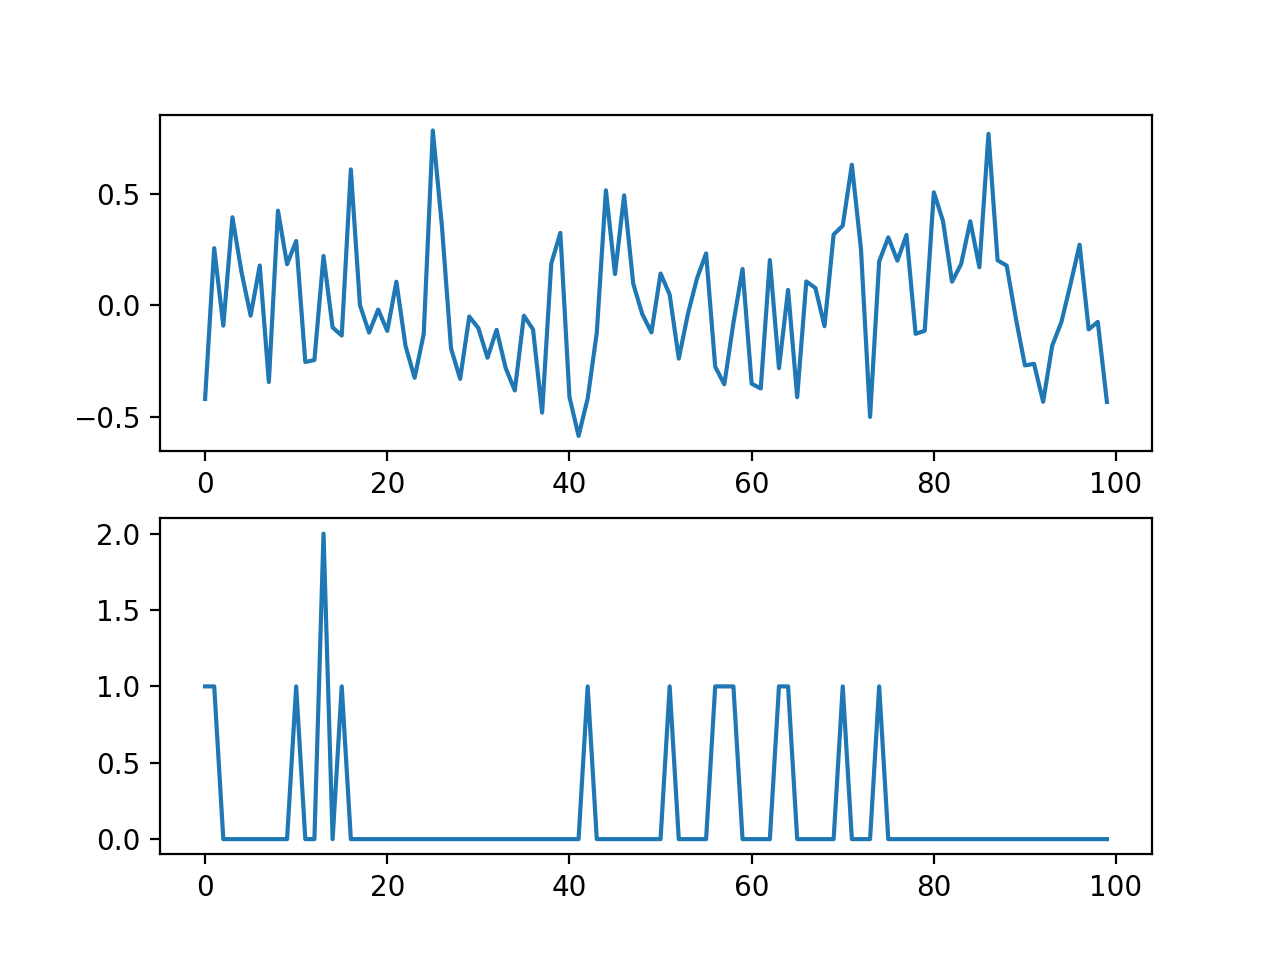

In [3]:
# simulate Poisson GLM with autoregressive stimulus filter
w = np.array([ 2.5, 0.0, 0.0, 0.0, -0.01368046, -0.01986828,
 -0.03867417, -0.05218188, -0.10044614, -0.12434759, -0.19540891, -0.23327453,
 -0.32255702, -0.40001292, -0.46124429, -0.46235415, -0.43928836, -0.52066692,
 -0.58597496, -0.15804368,  1.2849799,   1.91338741,  1.10402054,  0.23188751,
  0.00331092, -0.0111924, ])
D = np.shape(w)[0]
print(D)

T = 20000 # time bins

# binary stimulus
x = np.random.randint(0,2,[T,])-0.5
# x = np.random.randint(0,2,[T,])

# Gaussian stimulus
x = 0.3*np.random.randn(T)

# spiking bin size
dtSp = 0.01 

# generate design matrix 
X = hankel(np.append(np.zeros(D-2),x[:T-D+2]),x[T-D+1:])
X = np.concatenate((np.ones([T,1]),X),axis=1)

# generate spikes 
y = np.random.poisson(np.exp(X@w)*dtSp)

# look at data
plt.figure()
plt.subplot(2,1,1)
plt.plot(x[:100])
plt.subplot(2,1,2)
plt.plot(y[:100])

In [4]:
# statistics of data
print(np.log(np.mean(y/dtSp)))
print(np.log(np.std(y/dtSp)))

# print()

2.8713021951758138
3.8234453987489037


In [5]:
# prior
lambda_ridge = np.power(2.0,4)
lambda_ridge = 0.0
Cinv = lambda_ridge*np.eye(D)
Cinv[0,0] = 0.0 # no prior on bias

# fit with paGLM
# xlim = [-0.5,5.5] # binary - 0.5
# xlim = [-5,11] # binary - 0.5
# xlim = [0,5.5] # binary
# xlim = [1.,4.] # Gaussian
xlim = [0.5,4.5] # Gaussian
a,b,c = compute_chebyshev(np.exp,xlim,power=2,dx=0.01)
w_pass = np.linalg.lstsq(2.0*c*dtSp*X.T@X+Cinv,X.T @ (y-b*dtSp),rcond=True)[0]

2.4792929957379664e-13


<IPython.core.display.Javascript object>


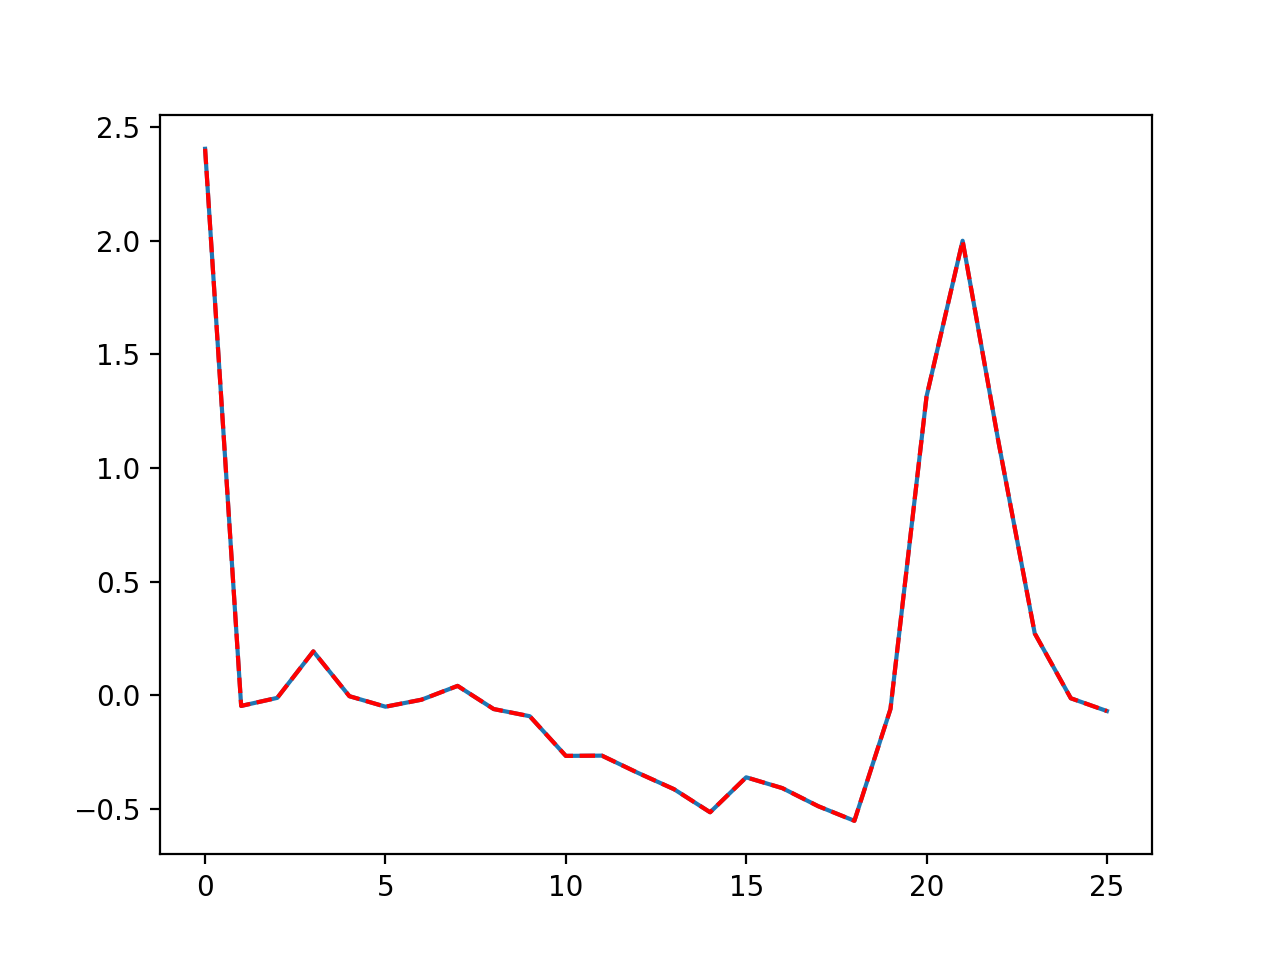

In [8]:
intervals = [xlim]
w_pass2 = fit_paglm(np.exp,X,y,dtSp,intervals,Cinv=Cinv,subset_frac=0.1)
print(np.linalg.norm(w_pass-w_pass2))

plt.figure()
plt.plot(w_pass)
plt.plot(w_pass2,'r--')

In [6]:
# fit with MAP
from scipy.optimize import minimize
res = minimize(lambda w: poisson_neg_like(w,y,X,Cinv,dtSp), np.zeros([D,]),method='L-BFGS-B', tol=1e-4,jac=True,options={'disp': True})
w_map = res.x

NameError: name 'poisson_neg_like' is not defined

In [124]:
sample_cov = np.cov(X[:,1:].T)
print(sample_cov[0,0])

0.08923660996979267


In [125]:
# fit will ELL
Cov = (0.3**2)*np.eye(D-1)
# Cov = 1*np.eye(D-1)
# Cov = 0.25*np.eye(D-1)
X_demeaned = X - np.mean(X,0,keepdims=True)
w_ell = np.zeros(D)
w_ell[1:] = np.linalg.lstsq(np.sum(y)*Cov,X_demeaned[:,1:].T@y,rcond=True)[0]
w_ell[0] = np.log(np.sum(y)/np.size(y)/dtSp * np.exp( - w_ell[1:].T@Cov@w_ell[1:]/2.0))

<IPython.core.display.Javascript object>


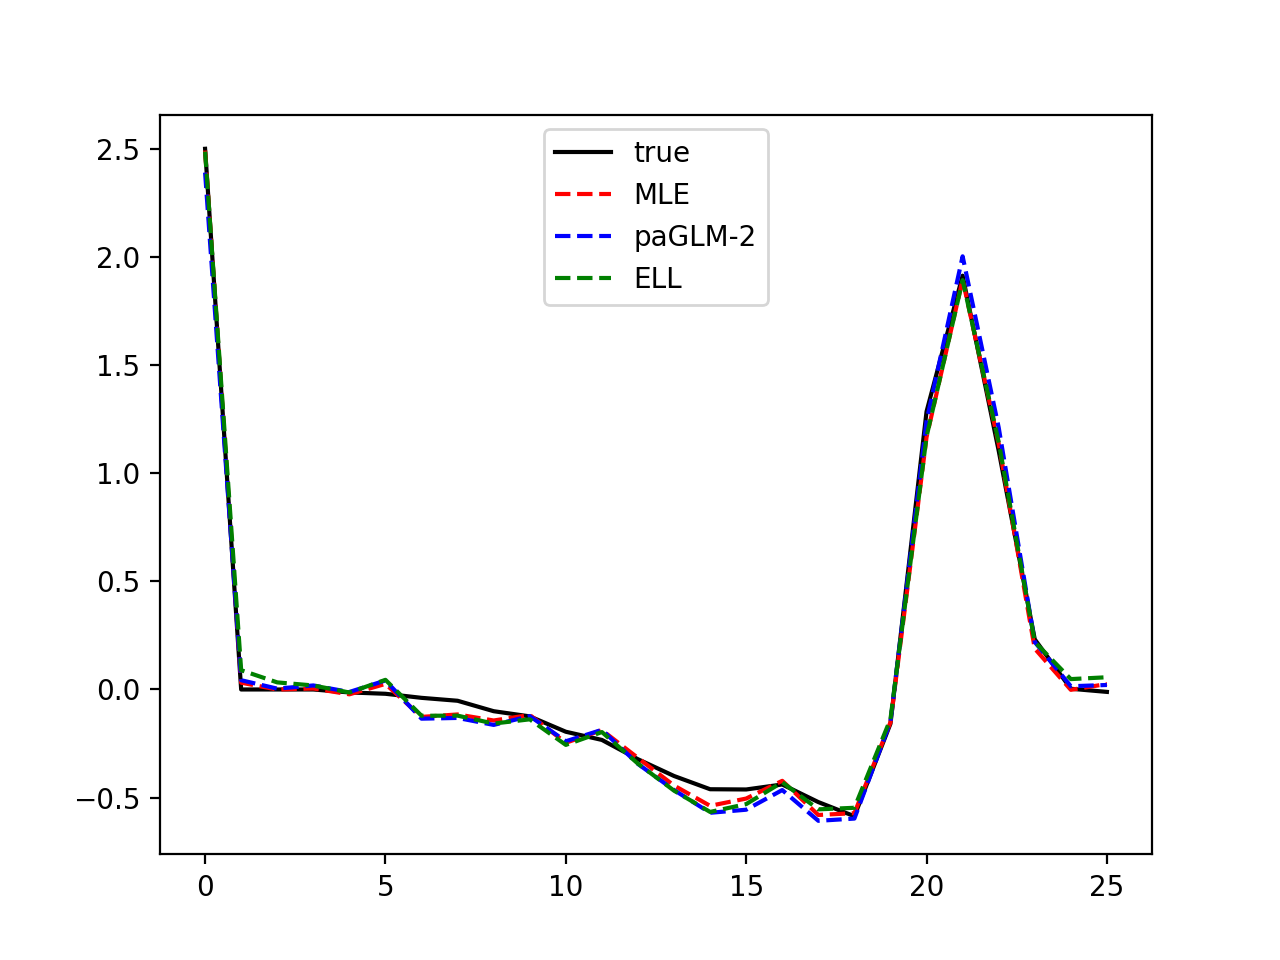

In [126]:
# compare solutions
plt.figure()
plt.plot(w,'k')
plt.plot(w_map,'r--')
plt.plot(w_pass,'b--')
plt.plot(w_ell,'g--')
plt.legend(['true','MLE','paGLM-2','ELL'])
# plt.savefig('comparison_with_ell.png')

In [76]:
Xsum = np.sum(X,axis=1)
print(np.shape(Xsum))
print(np.log(np.mean(np.divide(y,Xsum)/dtSp)))

(20000,)
3.809436963563578


In [84]:
Xsum2 = np.sum(X[:,1:],axis=1)
print(np.mean(Xsum2))
print(np.std(Xsum2))

0.006874023755099892
0.9838961832407653


<IPython.core.display.Javascript object>


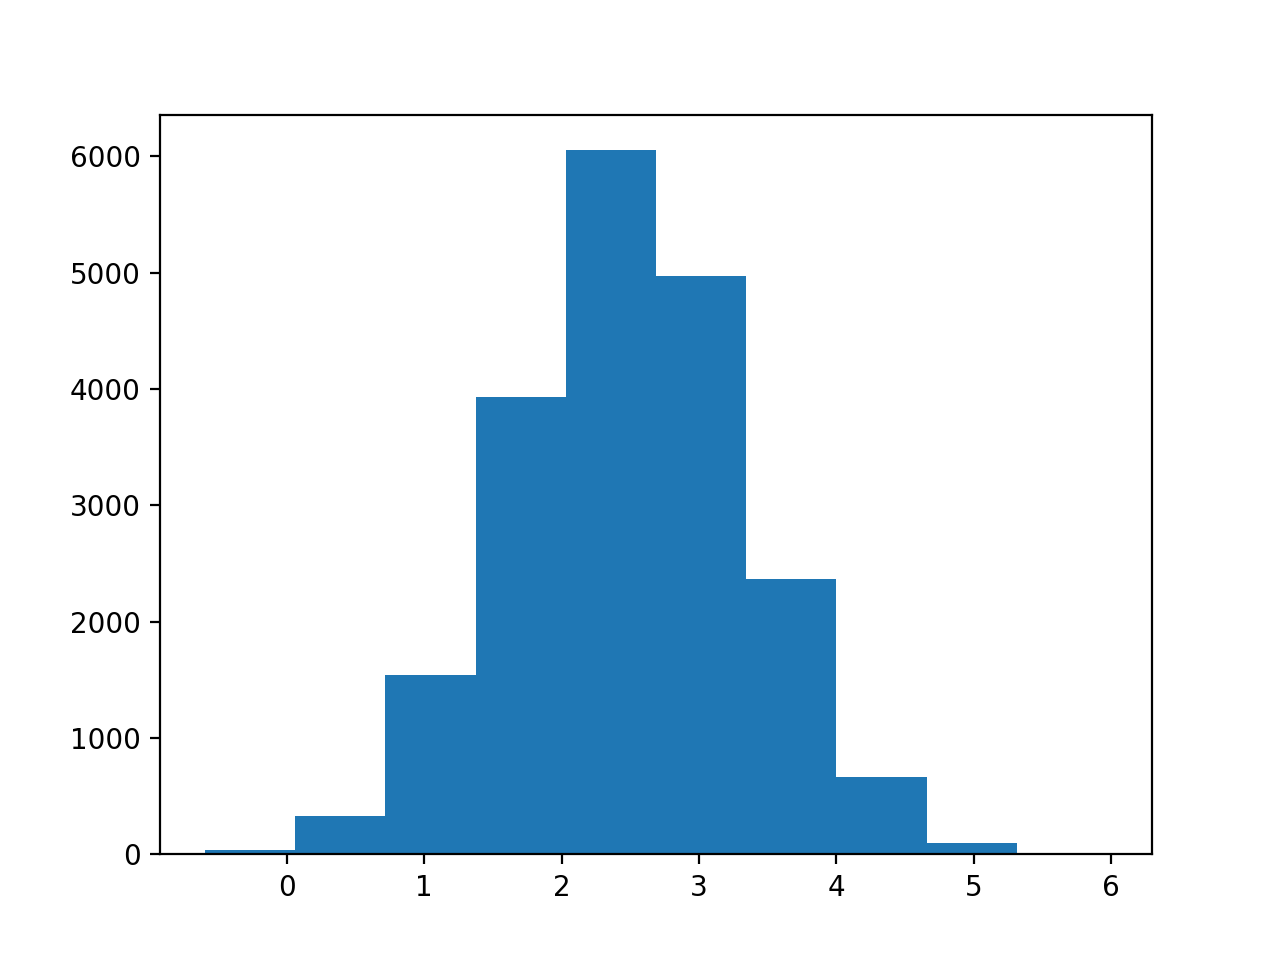

(array([  35.,  330., 1544., 3931., 6050., 4968., 2367.,  668.,   94.,
          13.]),
 array([-0.59572488,  0.06094879,  0.71762245,  1.37429612,  2.03096979,
         2.68764346,  3.34431712,  4.00099079,  4.65766446,  5.31433812,
         5.97101179]),
 <a list of 10 Patch objects>)

In [121]:
plt.figure()
plt.hist(X@w_map)
# plt.hist(X[:,1:]@w_map[1:])
# plt.axvline(np.log(np.mean(y)/dtSp),color='k')
# plt.axvline(np.mean(X@w_map),color='r')